In [2]:
%load_ext autoreload
%autoreload 2

import optuna
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import shap
import numpy as np
import scipy
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from utils.model import predict, load_model, Metrics, save_model, lgb_booster_to_model, load_final_model, save_final_model, load_final_model

SEED = 42

In [3]:
from utils.pipeline import Pipeline, PipelineStep

from steps.set_missings import set_missings, drop_fraud
from utils.helpers import reduce_mem_usage
from steps.load_data import load_train_data, load_test_data
from steps.feature_selection import feature_selection
from steps.dpi_features import generate_test_dpi_feature, generate_train_dpi_feature
from steps.bnum_features import generate_test_bnum_feature, generate_train_bnum_feature
from steps.fe_features import generate_test_fe_feature, generate_train_fe_feature


def remove_abon_id(df):
    return df.drop("abon_id", axis=1)


transform_train_pipeline = Pipeline(
    "TRANSFORM_TRAIN",
    [
        # Load data
        PipelineStep(load_train_data),
        PipelineStep(set_missings),
        PipelineStep(reduce_mem_usage),
        # New features
        PipelineStep(generate_train_fe_feature),
        PipelineStep(generate_train_dpi_feature),
        PipelineStep(generate_train_bnum_feature),
        PipelineStep(drop_fraud),
        # Feature selection
        PipelineStep(remove_abon_id),
        PipelineStep(feature_selection),
    ],
)

transform_test_pipeline = Pipeline(
    "TRANSFORM_TEST",
    [
        # Load data
        PipelineStep(load_test_data),
        PipelineStep(set_missings),
        PipelineStep(reduce_mem_usage),
        # New features
        PipelineStep(generate_test_fe_feature),
        PipelineStep(generate_test_dpi_feature),
        PipelineStep(generate_test_bnum_feature),
        # Feature selection
        PipelineStep(remove_abon_id),
        PipelineStep(feature_selection),
    ],
)

In [ ]:
train_data = transform_train_pipeline.run()

print("Shape:", train_data.shape)
print("Columns:", train_data.columns)

In [4]:
import pickle

cache_key = "cache/train_data_pipeline.pkl"

# with open(cache_key, "wb") as f:
#     pickle.dump(train_data, f)

with open(cache_key, "rb") as f:
    train_data = pickle.load(f)

In [ ]:
test_data = transform_test_pipeline.run()

print("Shape:", test_data.shape)
print("Columns:", test_data.columns)

In [5]:
import pickle

cache_key = "cache/test_data_pipeline.pkl"

# with open(cache_key, "wb") as f:
#     pickle.dump(test_data, f)

with open(cache_key, "rb") as f:
    test_data = pickle.load(f)

In [396]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


def oversampling(train_data, size=0.6):
    train_x = train_data.drop(columns="target")
    train_y = train_data.target

    not_churn_data_count = train_data[train_data.target == 0].shape[0]

    not_churn_count_strategy = int(not_churn_data_count * size)
    churn_count_strategy = int(not_churn_data_count * size)

    rus = RandomUnderSampler(random_state=SEED, sampling_strategy={0: not_churn_count_strategy})
    train_x, train_y = rus.fit_resample(train_x, train_y)

    smote = SMOTE(random_state=SEED, sampling_strategy={0: not_churn_count_strategy, 1: churn_count_strategy})
    resampled_x, resampled_y = smote.fit_resample(train_x, train_y)

    return resampled_x, resampled_y


resampled_x, resampled_y = oversampling(train_data)

In [397]:
model_params = {
    "random_state": SEED,
    "seed": SEED,
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "feature_pre_filter": False,
    "lambda_l1": 8.916226764803635,
    "lambda_l2": 9.574590549401839,
    "learning_rate": 0.07518766667831955,
    "num_leaves": 85,
    "feature_fraction": 0.3888218905277871,
    "max_depth": 15,
    "early_stopping_rounds": 100,
}

In [353]:
# dtrain = lgb.Dataset(train_x, label=train_y)
# dvalid = lgb.Dataset(val_x, label=val_y, reference=dtrain)

# model = lgb.train(model_params, dtrain, valid_sets=[dvalid])

In [398]:
model_params.pop("early_stopping_rounds")

model_cls = lgb.LGBMClassifier(**model_params)

model_cls = model_cls.fit(resampled_x, resampled_y)

In [405]:
train_X = train_data[resampled_x.columns]
train_y_true = train_data.target

train_y_pred_proba = model_cls.booster_.predict(train_X)
train_y_pred = (train_y_pred_proba >= 0.5).astype(int)

Metrics().call(train_y_true, train_y_pred, train_y_pred_proba)

print("model_cls.booster_Columns count ", len(resampled_x.columns))


Metrics
AUC: 0.933
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97    140413
         1.0       0.65      0.48      0.56      9585

    accuracy                           0.95    149998
   macro avg       0.81      0.73      0.76    149998
weighted avg       0.95      0.95      0.95    149998

model_cls.booster_Columns count  612


In [408]:
test_X = test_data[resampled_x.columns]
test_y_true = test_data.target

test_y_pred_proba = model_cls.booster_.predict(test_X)
test_y_pred = (test_y_pred_proba >= 0.5).astype(int)

Metrics().call(test_y_true, test_y_pred, test_y_pred_proba)

print("model_cls.booster_Columns count ", len(resampled_x.columns))


Metrics
AUC: 0.898
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97    140597
         1.0       0.59      0.43      0.49      9403

    accuracy                           0.95    150000
   macro avg       0.77      0.70      0.73    150000
weighted avg       0.94      0.95      0.94    150000

model_cls.booster_Columns count  612


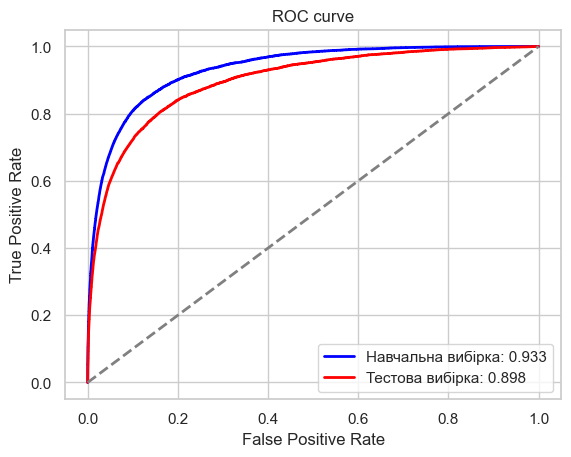

In [438]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    fpr1, tpr1, _ = roc_curve(y_train, y_train_pred)
    roc_auc1 = auc(fpr1, tpr1)

    fpr2, tpr2, _ = roc_curve(y_test, y_test_pred)
    roc_auc2 = auc(fpr2, tpr2)

    plt.figure()
    plt.plot(fpr1, tpr1, color="blue", lw=2, label=f"Навчальна вибірка: {roc_auc1:.3f}")
    plt.plot(fpr2, tpr2, color="red", lw=2, label=f"Тестова вибірка: {roc_auc2:.3f}")
    plt.plot([0, 1], [0, 1], color="grey", lw=2, linestyle="--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend(loc="lower right")
    plt.show()


plot_roc_curve(train_y_true, train_y_pred_proba, test_y_true, test_y_pred_proba)

In [56]:
save_final_model(model_cls, "BEST_LightGbmV2_pipeline_p059_r043_090auc_2", list(resampled_x.columns))

Save BEST_LightGbmV2_pipeline_p059_r043_090auc_2


'BEST_LightGbmV2_pipeline_p059_r043_090auc_2'

In [153]:
model_clf, _ = load_final_model("BEST_LightGbmV2_pipeline_p059_r043_090auc_2.pickle")

In [287]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_model_platt = CalibratedClassifierCV(estimator=model_cls, method="isotonic", cv="prefit")

calibrated_model_platt.fit(train_data[resampled_x.columns], train_data.target)

CalibratedClassifierCV(cv='prefit',
                       estimator=LGBMClassifier(feature_fraction=0.3888218905277871,
                                                feature_pre_filter=False,
                                                lambda_l1=8.916226764803636,
                                                lambda_l2=9.574590549401838,
                                                learning_rate=0.07518766667831955,
                                                max_depth=15, metric='auc',
                                                num_leaves=85,
                                                objective='binary',
                                                random_state=42, seed=42,
                                                verbosity=-1),
                       method='isotonic')

In [440]:
from sklearn.metrics import brier_score_loss, log_loss

X = train_data[resampled_x.columns]
y_true = train_data.target

prob_pos_calibrated_isotonic = calibrated_model_platt.predict_proba(X)[:, 1]
calibrated_test_y_pred = (prob_pos_calibrated_isotonic >= 0.5).astype(int)

prob_pos = model_cls.booster_.predict(X)

print("Brier score before Isotonic calibration: ", brier_score_loss(y_true, prob_pos))
print("Brier score after Isotonic calibration: ", brier_score_loss(y_true, prob_pos_calibrated_isotonic))
print("Log loss before Isotonic calibration: ", log_loss(y_true, prob_pos))
print("Log loss after Isotonic calibration: ", log_loss(y_true, prob_pos_calibrated_isotonic))

Metrics().call(y_true, calibrated_test_y_pred, prob_pos_calibrated_isotonic)

Brier score before Isotonic calibration:  0.03847948645208176
Brier score after Isotonic calibration:  0.03676543616512603
Log loss before Isotonic calibration:  0.14378963673558298
Log loss after Isotonic calibration:  0.13061607689865004

Metrics
AUC: 0.934
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97    140413
         1.0       0.71      0.41      0.52      9585

    accuracy                           0.95    149998
   macro avg       0.83      0.70      0.75    149998
weighted avg       0.94      0.95      0.95    149998



(0.9335198451251869,
 '              precision    recall  f1-score   support\n\n         0.0       0.96      0.99      0.97    140413\n         1.0       0.71      0.41      0.52      9585\n\n    accuracy                           0.95    149998\n   macro avg       0.83      0.70      0.75    149998\nweighted avg       0.94      0.95      0.95    149998\n')

In [265]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

X = train_data[resampled_x.columns]
y_true = train_data.target

# Get learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    lgb.LGBMClassifier(**model_params),
    X,
    y_true,
    cv=10,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring="roc_auc",
)

/Users/yaroslav/.pyenv/versions/3.10.13/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [300]:
def build_learning_curve_plt(train_sizes, train_scores, val_scores):
    # Calculate mean and standard deviation for training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    # Витягнення даних з найвищими середніми оцінками
    best_train_index = np.argmax(train_scores_mean)
    best_test_index = np.argmax(train_scores_mean)

    best_train_size = train_sizes[best_train_index]
    best_train_score_mean = train_scores_mean[best_train_index]
    best_train_score_std = train_scores_std[best_train_index]

    # Plot learning curve
    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("ROC-AUC Score")
    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g"
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, "o-", color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

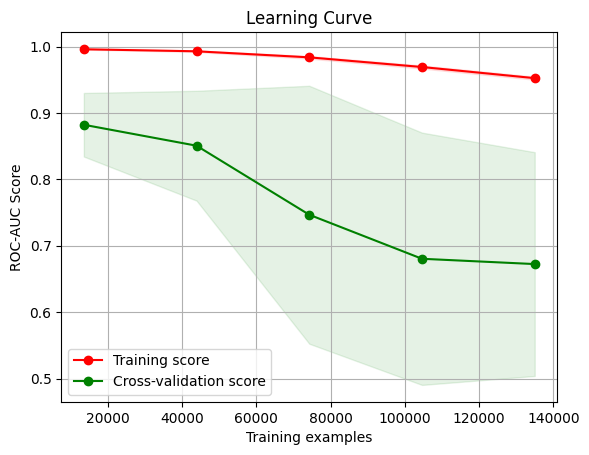

In [301]:
build_learning_curve_plt(train_sizes, train_scores, val_scores)

In [334]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


def find_threshold(y_test, y_pred_proba):
    # Define a range of possible thresholds
    thresholds = np.linspace(0, 1, 100)
    accuracies = []

    # Calculate accuracy for each threshold
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        accuracies.append(accuracy_score(y_test, y_pred))

    # Find the threshold that provides the highest accuracy
    max_accuracy_index = np.argmax(accuracies)
    optimal_threshold = thresholds[max_accuracy_index]

    print(f"Optimal Threshold for Maximum Accuracy: {optimal_threshold}")
    print(f"Maximum Accuracy: {accuracies[max_accuracy_index]}")

    # Plotting accuracy vs threshold
    plt.plot(thresholds, accuracies, label="Accuracy")
    plt.scatter(
        thresholds[max_accuracy_index],
        accuracies[max_accuracy_index],
        marker="o",
        color="red",
        label="Best Threshold",
    )
    plt.title("Accuracy vs. Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    return optimal_threshold

Optimal Threshold for Maximum Accuracy: 0.5757575757575758
Maximum Accuracy: 0.9515993546580621


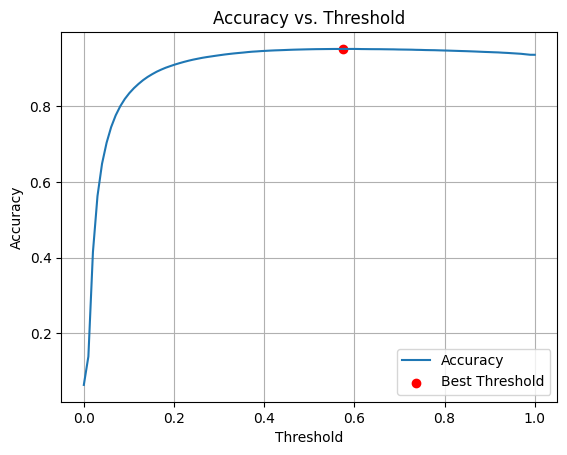

In [335]:
optimal_threshold = find_threshold(train_y_true, train_y_pred_proba)

In [439]:
test_X = test_data[resampled_x.columns]
test_y_true = test_data.target

test_y_pred_proba = model_cls.booster_.predict(test_X)
test_y_pred = (test_y_pred_proba >= optimal_threshold).astype(int)

Metrics().call(test_y_true, test_y_pred, test_y_pred_proba)

print("model_cls.booster_Columns count ", len(resampled_x.columns))


Metrics
AUC: 0.898
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97    140597
         1.0       0.64      0.37      0.47      9403

    accuracy                           0.95    150000
   macro avg       0.80      0.68      0.72    150000
weighted avg       0.94      0.95      0.94    150000

model_cls.booster_Columns count  612
